In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from scipy import interpolate

# Data Processing

In [2]:
columns = ["timestamp", "activity", "heartrate", ]
columns += [f"hand-{i}" for i in range(1,18)]
columns += [f"chest-{i}" for i in range(1,18)]
columns += [f"ankle-{i}" for i in range(1,18)]

In [3]:
dataframes = []
for subject in range(102, 110):
    df = pd.read_table(f'./PAMAP2_Dataset/Protocol/subject{subject}.dat', sep='\s+')
    df.columns = columns
    print(np.unique(df['activity'].values))
    dataframes.append(df)
data = pd.concat(dataframes, ignore_index=True)
print("Data shape:", data.shape)

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]
[ 0  1  2  3  4 12 13 16 17]
[ 0  1  2  3  4  5  6  7 12 13 16 17]
[ 0  1  2  3  4  5  6  7 12 13 16 17 24]
[ 0  1  2  3  4  5  6  7 12 13 16 17 24]
[ 0  1  2  3  4  5  6  7 12 13 16 17]
[ 0  1  2  3  4  5  6  7 12 13 16 17 24]
[ 0 24]
Data shape: (2496108, 54)


In [4]:
df_test = pd.read_table(f'./PAMAP2_Dataset/Protocol/subject101.dat', sep='\s+')
df_test.columns = columns
print(np.unique(df_test['activity'].values))

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]


In [5]:
data.head()

,timestamp,activity,heartrate,hand-1,hand-2,hand-3,hand-4,hand-5,hand-6,hand-7,...,ankle-8,ankle-9,ankle-10,ankle-11,ankle-12,ankle-13,ankle-14,ankle-15,ankle-16,ankle-17
0,5.65,0,NaN,33.0,2.86086,7.43814,-7.21626,2.84248,7.63164,-6.85140,...,0.012804,-0.036384,-0.014845,-47.7624,-2.81438,60.3407,0.014025,-0.748410,0.079043,-0.658360
1,5.66,0,100.0,33.0,2.80997,7.09430,-7.52376,2.79373,7.43545,-7.07744,...,-0.001695,-0.034529,-0.040074,-47.5393,-2.38909,60.9623,0.012714,-0.749508,0.075286,-0.657577
2,5.67,0,NaN,33.0,2.77138,6.98077,-7.52396,2.80627,7.29929,-7.24326,...,0.055437,-0.011560,0.015434,-47.4246,-2.72082,60.7103,0.012639,-0.749201,0.076030,-0.657843
3,5.68,0,NaN,33.0,2.76710,7.13119,-7.67848,2.78766,7.11797,-7.48445,...,0.017184,-0.034663,0.007239,-47.5412,-2.60153,60.3412,0.012571,-0.749291,0.076346,-0.657705
4,5.69,0,NaN,33.0,2.60926,7.13068,-7.87328,2.81630,7.17794,-7.72623,...,-0.015741,-0.053576,0.026668,-47.5325,-3.15502,60.4590,0.013169,-0.749205,0.077813,-0.657620


Here is the breakdown of each of the 17 parameters of the IMU data (hand, chest and ankle)
+ 1 temperature (°C)
+ 2-4 3D-acceleration data (ms-2),  scale: ±16g, resolution: 13-bit
+ 5-7 3D-acceleration data (ms-2),  scale: ±6g, resolution: 13-bit*
+ 8-10 3D-gyroscope data (rad/s)
+ 11-13 3D-magnetometer data (μT)
+ 14-17 orientation (invalid in this data collection)

Out of these, temperature is unnecessary. The second accelerometer (5-7) data is imprecise, we use just the first one.
Orientation (14-17) is invalid for this data. We remove this from our dataset. Finally, order is all that matters, timestep value is irrelevant. We drop that row too.

In [6]:
data.columns

Index(['timestamp', 'activity', 'heartrate', 'hand-1', 'hand-2', 'hand-3',
       'hand-4', 'hand-5', 'hand-6', 'hand-7', 'hand-8', 'hand-9', 'hand-10',
       'hand-11', 'hand-12', 'hand-13', 'hand-14', 'hand-15', 'hand-16',
       'hand-17', 'chest-1', 'chest-2', 'chest-3', 'chest-4', 'chest-5',
       'chest-6', 'chest-7', 'chest-8', 'chest-9', 'chest-10', 'chest-11',
       'chest-12', 'chest-13', 'chest-14', 'chest-15', 'chest-16', 'chest-17',
       'ankle-1', 'ankle-2', 'ankle-3', 'ankle-4', 'ankle-5', 'ankle-6',
       'ankle-7', 'ankle-8', 'ankle-9', 'ankle-10', 'ankle-11', 'ankle-12',
       'ankle-13', 'ankle-14', 'ankle-15', 'ankle-16', 'ankle-17'],
      dtype='object')

In [7]:
data.drop(columns=['timestamp']+[ f"{place}-{number}" for place in ["hand", "chest", "ankle"] for number in [1, 5, 6, 7, 14, 15, 16, 17]], inplace=True)

In [8]:
df_test.drop(columns=['timestamp']+[ f"{place}-{number}" for place in ["hand", "chest", "ankle"] for number in [1, 5, 6, 7, 14, 15, 16, 17]], inplace=True)

In [9]:
data.head()

,activity,heartrate,hand-2,hand-3,hand-4,hand-8,hand-9,hand-10,hand-11,hand-12,...,chest-13,ankle-2,ankle-3,ankle-4,ankle-8,ankle-9,ankle-10,ankle-11,ankle-12,ankle-13
0,0,NaN,2.86086,7.43814,-7.21626,1.08269,-0.393965,1.60935,-11.6575,-3.186480,...,8.30648,9.83968,-0.807666,-1.80115,0.012804,-0.036384,-0.014845,-47.7624,-2.81438,60.3407
1,0,100.0,2.80997,7.09430,-7.52376,1.14829,-0.521087,1.80748,-11.7615,-2.530610,...,8.68295,9.69127,-0.769071,-1.76432,-0.001695,-0.034529,-0.040074,-47.5393,-2.38909,60.9623
2,0,NaN,2.77138,6.98077,-7.52396,1.24888,-0.511985,1.95031,-11.2109,-2.121300,...,8.18545,9.80276,-0.921656,-1.76223,0.055437,-0.011560,0.015434,-47.4246,-2.72082,60.7103
3,0,NaN,2.76710,7.13119,-7.67848,1.27178,-0.525704,2.01367,-10.8648,-0.621037,...,8.68756,9.68318,-0.842759,-2.03407,0.017184,-0.034663,0.007239,-47.5412,-2.60153,60.3412
4,0,NaN,2.60926,7.13068,-7.87328,1.30517,-0.563694,2.06970,-10.9776,-0.395412,...,8.43012,9.80315,-0.845719,-1.76270,-0.015741,-0.053576,0.026668,-47.5325,-3.15502,60.4590


In [10]:
def interpolate_linear(data_pd):
    # Sensor polling rates are not the same. Interpolating NaN values.
    for key, value in data_pd.items():
        if value.isna().any():
            nan_values = value.isna()
            numeric_values = ~nan_values
            data_pd.loc[nan_values, key] = np.interp(np.flatnonzero(nan_values), np.flatnonzero(numeric_values), value[numeric_values])

def remove_heart_noise(data_np):
    data_heartfixed = data_np.copy()
    hrate = data_heartfixed[:, 2]
    nan_indices = np.argwhere(~np.isnan(hrate)).flatten()
    nan_indices.sort()
    for idx in range(0, len(nan_indices)-1, 8):
        vals = [ nan_indices[idx+i]for i in range(8) if idx+i < len(nan_indices) ]
        avg = np.mean(hrate[vals])
        hrate[vals] = np.nan
        hrate[vals[len(vals)//2]] = avg
    return data_heartfixed

def interpolate_cubic(data_np):
    data_clean_np = np.zeros_like(data_np)
    data_clean_np[:, 0:2] = data_np[:, 0:2]
    for idx, values in enumerate(data_np[:, 2:].T):
        timestamps = data_np[:, 0]
        timestamps_notnan = timestamps[~np.isnan(values)]
        values_notnan = values[~np.isnan(values)]
        values = interpolate.CubicSpline(timestamps_notnan, values_notnan)(timestamps)
        data_clean_np[:, 2+idx] = values.T
    return data_clean_np

In [11]:
interpolate_linear(data)
interpolate_linear(df_test)

In [12]:
X_train = data.loc[:, data.columns != 'activity'].to_numpy()
y_train = data['activity'].to_numpy()

X_test = df_test.loc[:, df_test.columns != 'activity'].to_numpy()
y_test = df_test['activity'].to_numpy()

print()
print(f"{X_train.shape = }", f"{X_test.shape = }", f"{y_train.shape = }", f"{y_test.shape = }", sep="\n")


X_train.shape = (2496108, 28)
X_test.shape = (376416, 28)
y_train.shape = (2496108,)
y_test.shape = (376416,)


In [13]:
import sys
import pickle
import numpy as np
from time import time
import sklearn.metrics
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

In [14]:
start_time = time()

dt = DecisionTreeClassifier(max_depth=50, random_state=42)
dt.fit(X_train, y_train)
train_dur = time() - start_time

y_pred_test = dt.predict(X_test)
acc_test = sklearn.metrics.accuracy_score(y_test, y_pred_test)
print(f"Accuracy test: {acc_test}")
confusion_matrix_test = sklearn.metrics.confusion_matrix(y_test, y_pred_test)
class_rep = sklearn.metrics.classification_report(y_test, y_pred_test)

y_pred_train = dt.predict(X_train)
acc_train = sklearn.metrics.accuracy_score(y_train, y_pred_train)

Accuracy test: 0.3775264600867126


In [15]:
def plot_confusion_matrix(conf_matrix, show_none = True):
    class_names = ['none','lie','sit','stand','walk','run','cycle','nordic_walk','ascend_stairs','descend_stairs','vacuum_clean','iron','rope_jumping']
    if not show_none:
        conf_matrix = conf_matrix[1:,1:]
        class_names = class_names[1:]
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, conf_matrix[i, j],
                        ha="center", va="center", color="white")
            
    ax.set_title("Confusion matrix")
    plt.colorbar(im)

    plt.show()

In [16]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]


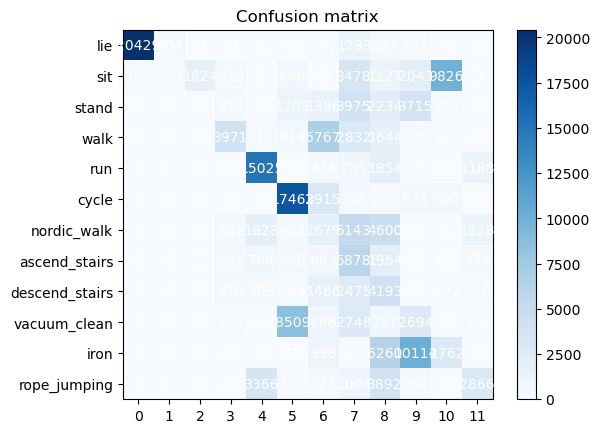

In [17]:
plot_confusion_matrix(confusion_matrix_test, show_none=False)